In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
from collections import defaultdict
import simpy as sp

plt.rcParams['text.usetex'] = True

In [2]:
def harmonic(N, s):
    harmonic_sum = 0
    for k in range(1,N+1):
        harmonic_sum += 1/(k**s)
    return harmonic_sum

def zipf(k, N, s):
    return 1 / (harmonic(N,s) * k**s)

def avgPackets(cap,rate):
    return rate/(cap-rate)

def offlineReqGen(N, zipf_param, exp_rate, gen_time):
    rng = default_rng(123)
    prob_dist = [zipf(k, N, zipf_param) for k in range(1,N+1)]
    intervals = []
    objects = []
    timestamps = defaultdict(list)
    t = 0
    while t < gen_time:
        interval = rng.exponential(1/exp_rate)
        intervals.append(interval)
        objects.append(rng.choice(np.arange(1,N+1), p = prob_dist))
        t += interval
    interval_cumsum = np.cumsum(intervals)
    for ts, obj in zip(interval_cumsum, objects):
        timestamps[obj].append(ts)
    for obj in timestamps:
        timestamps[obj].reverse()
    return intervals, timestamps, objects


In [5]:
def toyExample(N, zipf_param, exp_rate, gen_time, cacheCap):
    env = sp.Environment()
    serverLink = sp.Resource(env, 1)
    linkRate = 100
    serverDelay = 0
    cacheLink = sp.Resource(env, 1)
    cache = []
    cacheRate = 100
    cacheDelay = 0
    intervals, timestamps, objects = offlineReqGen(N, zipf_param, exp_rate, gen_time)
    R = len(objects)

    def serverProcess(obj):
        nonlocal serverDelay
        with serverLink.request() as request:
            tic = env.now
            yield request
            yield env.timeout(1/linkRate)
            toc = env.now
            cacheDecision(obj)
            serverDelay += toc - tic
        return

    def cacheProcess():
        nonlocal cacheDelay
        with cacheLink.request() as request:
            tic = env.now
            yield request
            yield env.timeout(1/cacheRate)
            toc = env.now
            cacheDelay += toc - tic
        return

    def cacheDecision(obj):
        if len(cache) < cacheCap:
            cache.append(obj)
            return
        victim_timestamp = 0
        victim = None
        for pot_victim in cache:
            if len(timestamps[pot_victim]) == 0:
                victim = pot_victim
                break
            next_timestamp = timestamps[pot_victim][-1]
            if next_timestamp > victim_timestamp:
                victim = pot_victim
                victim_timestamp = next_timestamp
        cache.remove(victim)
        cache.append(obj)

    def requestProcess():
        for interval, obj in zip(intervals, objects):
            yield env.timeout(interval)
            ts = timestamps[obj].pop()
            if obj in cache:
                env.process(cacheProcess())
            else:
                env.process(serverProcess(obj))

    env.process(requestProcess())
    env.run(until=gen_time+100)

    return (serverDelay + cacheDelay)/R

5 done.
10 done.
25 done.
50 done.
100 done.


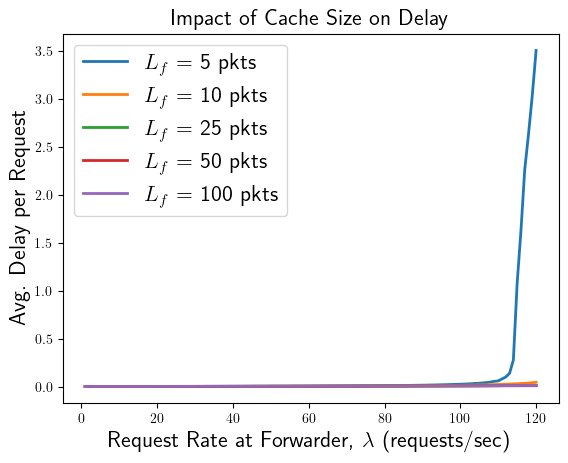

In [7]:
cacheCaps = [5,10,25,50,100]
reqRates = list(range(1,121))

for cap in cacheCaps:
    delay = [toyExample(1000,0.75,reqRate,100,cap) for reqRate in reqRates]
    plt.plot(reqRates,delay,linewidth=2)
    print(f'{cap} done.')
plt.xlabel("Request Rate at Forwarder, "+r"$\lambda$"+" (requests/sec)",fontsize=16)
plt.ylabel(r"Avg. Delay per Request",fontsize=16)
plt.title(f"Impact of Cache Size on Delay",fontsize=16)
plt.legend([r"$L_f$ = 5 pkts",r"$L_f$ = 10 pkts",r"$L_f$ = 25 pkts",r"$L_f$ = 50 pkts",r"$L_f$ = 100 pkts"],fontsize=16)